###Dataset overlap
just like in 'Don’t Stop Pretraining: Adapt Language Models to Domains and Tasks'. executed localy.

In [1]:
# code from https://github.com/allenai/dont-stop-pretraining slightly changed
from tqdm.notebook import tqdm
from sklearn.feature_extraction.text import CountVectorizer
import json
from itertools import combinations
import seaborn as sns
!pip install --upgrade matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import matplotlib
from os.path import getsize
from glob import glob
from random import sample
import pandas as pd
from multiprocessing import Pool
import nltk
# nltk.download()
import sys
def i1():# helper function for fork printing
  sys.stdout.write('')
  sys.stdout.flush()

In [2]:
def read_file(fi, maxx=0):
  """ helper function for loading txts 
      if max!=0 it reads ~maxx bytes"""
  ans = []
  block_size = 2048
  total = 0
  with open(fi, 'r') as f:
    def read_block():
      return f.read(block_size)
    # read file by blocks. (i dont know why total /1.8, but it almost works)
    if maxx!=0:
      for block in iter(read_block, ''):
        ans.append(block)
        total += block_size
        if total >= maxx:
          break
    else:
      for block in iter(read_block, ''):
        ans.append(block)
  return ans


def load_data(directory: str):
  """loads lines (or blocks) from all files in directory 
  and returns a list of them"""
  examples = []
  if 'RAPTARCHIS' in directory:
    files = glob(directory+'*.pkl')
    for f in tqdm(files, desc='loading RAPTARCHIS', leave=True):
      df = pd.read_pickle(f)
      examples = df['text'].values.tolist()
  elif 'Greek-Bert' in directory:
    files = glob(directory+'europal/*')
    files += sample(glob(directory+'oscar/*'),1)# choose a random file from oscar
    # files += glob(directory+'wiki/*')
    block_size = 2048
    for fi in tqdm(files, desc='loading Greek-Bert', leave=True):
      examples += read_file(fi, 37000000/2)
  elif 'Legal-Bert' in directory:
    files = sample(glob(directory+'*/*/*.txt'),4500)# choose random files from oscar
    with Pool(processes=16) as pool:
      results = list(tqdm(pool.imap(read_file, files), total=len(files),
                  desc='loading Legal-Bert', leave=True))
    examples = [item for sublist in results for item in sublist]
  return examples


def load_vocab(directory):
  """ makes a vocabulary from files in directory"""
  text = load_data(directory)
  if 'RAPTARCHIS' in directory:
    limit_max = 1.0
    limit_min = 4
    name = 'RAPTARCHIS'
  elif 'Greek-Bert' in directory:
    limit_max = 1.0
    limit_min = 4
    name = 'Greek-Bert'
  elif 'Legal-Bert' in directory:
    limit_max = 1.0
    limit_min = 5
    name = 'Legal-Bert'

  count_vectorizer = CountVectorizer(min_df=limit_min, max_df=limit_max,
                          stop_words=nltk.corpus.stopwords.words('greek'))
  count_vectorizer.fit(tqdm(text, desc=f'fitting vocab {name}', leave=True))
  vocab = set(count_vectorizer.vocabulary_.keys())

  print(f'{name} vocab size {len(vocab)}')
  return (directory, vocab)

In [3]:
original_path = "/mnt/D21005A6100592A1/ΕΚΠΑ/πτυχιακή/Bert-final/"

files = original_path+"datasets/Legal-Bert/normalized/"
results1 = load_vocab(files)

files = [original_path+"datasets/RAPTARCHIS/normalized/"]
files += [original_path+"datasets/Greek-Bert/normalized/"]
with Pool(processes=4, initializer=i1) as pool:
  results2 = list(pool.imap(load_vocab, files))
  
results = [results1] + results2
vocabs = {}
for res in results:
  if 'Greek-Bert' in res[0]:
    key = 'Greek-Bert'
  elif 'RAPTARCHIS' in res[0]:
    key = 'RAPTARCHIS'
  elif 'Legal-Bert' in res[0]:
    key = 'Legal-Bert'
  vocabs[key] = res[1]
file_pairs = combinations(list(vocabs.keys()), 2)

overlaps = {}
for x, y in file_pairs:
  intersection = vocabs[x] & vocabs[y]
  union = (vocabs[x] | vocabs[y])
  overlaps[x + "_" + y] = len(intersection) / len(union)

print("saving overlaps...")
with open(original_path+"dont_stop_pretraining/overlaps.json", "w+") as f:
  json.dump(overlaps, f)

/home/stratos/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['δι', 'ἀλλ'] not in stop_words.
  'stop_words.' % sorted(inconsistent))



Legal-Bert vocab size 66458



/home/stratos/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['δι', 'ἀλλ'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


/home/stratos/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['δι', 'ἀλλ'] not in stop_words.
  'stop_words.' % sorted(inconsistent))



Greek-Bert vocab size 54380

RAPTARCHIS vocab size 68027
saving overlaps...


findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


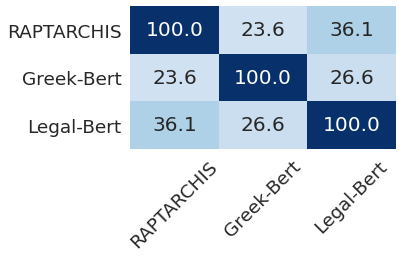

In [4]:
sns.set(context="paper", style="white", font_scale=2.1, font="Times New Roman") 

z = {}
for key in overlaps.keys():
  file_1, file_2 = key.split('_')
  if not z.get(file_1):
    z[file_1] = {}
  z[file_1][file_2] = overlaps[key]
  if not z.get(file_2):
    z[file_2] = {}
  z[file_2][file_1] = overlaps[key]
labels = ["RAPTARCHIS", "Greek-Bert", "Legal-Bert"]
data = []
for ix, key in enumerate(labels):
  items = []
  for subkey in labels:
    if not z[key].get(subkey):
      items.append(1.0)
    else:
      items.append(z[key][subkey])
  data.append(items)
data = np.array(data) * 100
ax = sns.heatmap(data, cmap="Blues", vmin=5, xticklabels=labels, 
                 annot=True, fmt=".1f", cbar=False, yticklabels=labels)
plt.yticks(rotation=0)
plt.xticks(rotation=45)
plt.tight_layout()